# Predicting BitCoin prices
1. Get historic stock prices
2. Extract prices to predict
3. Normalise
4. Create Time Series
5. Build model
6. Fit model
7. Test and evaluate

In [1]:
# Change Keras backend
from keras import backend as K
import os
os.environ['KERAS_BACKEND'] = "cntk"

In [2]:
# install dependencies
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
from keras.layers.core import Dense, Activation, Dropout
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from sklearn.model_selection import  train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [3]:
# 1. Get historic stock prices
data = pd.read_csv("../datasets/BTC/gemini_BTCUSD_2021_1min.csv")

# Data review

In [4]:
data.head()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
0,1633651440000,2021-10-08 00:04:00,BTCUSD,53744.05,53860.19,53744.05,53823.93,0.221051
1,1633651380000,2021-10-08 00:03:00,BTCUSD,53779.86,53780.74,53744.05,53744.05,0.140769
2,1633651320000,2021-10-08 00:02:00,BTCUSD,53857.19,53873.51,53779.86,53779.86,1.228199
3,1633651260000,2021-10-08 00:01:00,BTCUSD,53841.33,53857.19,53815.24,53857.19,1.203427
4,1633651200000,2021-10-08 00:00:00,BTCUSD,53791.32,53841.33,53789.36,53841.33,0.349098


In [5]:
data.tail()

,Unix Timestamp,Date,Symbol,Open,High,Low,Close,Volume
401636,1609459440000,2021-01-01 00:04:00,BTCUSD,29056.21,29056.21,29046.04,29048.46,0.032502
401637,1609459380000,2021-01-01 00:03:00,BTCUSD,29057.27,29057.27,29028.69,29056.21,0.049909
401638,1609459320000,2021-01-01 00:02:00,BTCUSD,29085.38,29086.14,29043.25,29057.27,5.075271
401639,1609459260000,2021-01-01 00:01:00,BTCUSD,29033.01,29086.14,29033.01,29085.38,1.451389
401640,1609459200000,2021-01-01 00:00:00,BTCUSD,28979.74,29033.01,28956.18,29033.01,0.126441


In [6]:
data.columns

Index(['Unix Timestamp', 'Date', 'Symbol', 'Open', 'High', 'Low', 'Close',
       'Volume'],
      dtype='object')

In [7]:
data.shape

(401641, 8)

In [8]:
data.describe()

,Unix Timestamp,Open,High,Low,Close,Volume
count,4.016410e+05,401641.000000,401641.000000,401641.000000,401641.000000,401641.000000
mean,1.621544e+12,44691.293977,44722.838424,44658.745469,44691.352793,1.678176
std,6.993811e+09,9049.033934,9049.989958,9047.992737,9049.014770,5.121604
min,1.609459e+12,27953.320000,28334.810000,27632.340000,27953.320000,0.000000
25%,1.615485e+12,36218.210000,36250.180000,36188.600000,36218.290000,0.090221
50%,1.621511e+12,45300.100000,45324.400000,45274.000000,45300.220000,0.396313
75%,1.627624e+12,51626.460000,51660.320000,51591.070000,51626.650000,1.424703
max,1.633651e+12,64890.000000,64900.000000,64775.620000,64890.000000,517.386068


In [9]:
data.dtypes

Unix Timestamp      int64
Date               object
Symbol             object
Open              float64
High              float64
Low               float64
Close             float64
Volume            float64
dtype: object

In [10]:
data.set_index('Unix Timestamp', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 401641 entries, 1633651440000 to 1609459200000
Data columns (total 7 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Date    401641 non-null  object 
 1   Symbol  401641 non-null  object 
 2   Open    401641 non-null  float64
 3   High    401641 non-null  float64
 4   Low     401641 non-null  float64
 5   Close   401641 non-null  float64
 6   Volume  401641 non-null  float64
dtypes: float64(5), object(2)
memory usage: 24.5+ MB


In [11]:
data.sort_index(inplace=True)

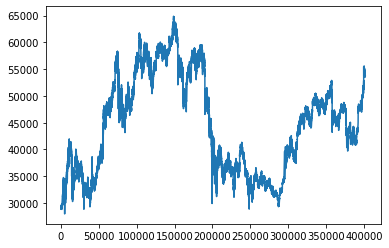

In [12]:
data_close = data['Close']
data_close = data_close.values.reshape(len(data_close), 1)
plt.plot(data_close)
plt.show()

In [13]:
scaler = MinMaxScaler(feature_range=(0,1))

In [14]:
data_close = scaler.fit_transform(data_close)
data_close

array([[0.02923084],
       [0.03064867],
       [0.02988763],
       ...,
       [0.69921119],
       [0.69824169],
       [0.70040431]])

In [15]:
# split data into train and test
train_size = int(len(data_close)*0.7)
test_size = len(data_close) - train_size

data_train, data_test = data_close[0:train_size, :], data_close[train_size:len(data_close), :]
print('Split data into train and test: ', len(data_train), len(data_test))

Split data into train and test:  281148 120493


In [16]:
# need to now convert the data into time series looking back over a period of days...e.g. use last 7 days to predict price
def create_ts(ds, series):
    X, Y =[], []
    for i in range(len(ds)-series - 1):
        item = ds[i:(i+series), 0]
        X.append(item)
        Y.append(ds[i+series, 0])
    return np.array(X), np.array(Y)

series = 7

trainX, trainY = create_ts(data_train, series)
testX, testY = create_ts(data_test, series)

In [17]:
trainX

array([[0.02923084, 0.03064867, 0.02988763, ..., 0.02964912, 0.02846899,
        0.02853532],
       [0.03064867, 0.02988763, 0.02985894, ..., 0.02846899, 0.02853532,
        0.02842784],
       [0.02988763, 0.02985894, 0.02964912, ..., 0.02853532, 0.02842784,
        0.02655815],
       ...,
       [0.09931753, 0.09954279, 0.09941446, ..., 0.0990866 , 0.09946481,
        0.09992939],
       [0.09954279, 0.09941446, 0.0990866 , ..., 0.09946481, 0.09992939,
        0.09940363],
       [0.09941446, 0.0990866 , 0.0990866 , ..., 0.09992939, 0.09940363,
        0.09859359]])

In [18]:
trainX[0]

array([0.02923084, 0.03064867, 0.02988763, 0.02985894, 0.02964912,
       0.02846899, 0.02853532])

In [19]:
# reshape into  LSTM format - samples, steps, features
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [20]:
# build the model
model = Sequential()
model.add(LSTM(4, input_shape=(series, 1)))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
# fit the model
model.fit(trainX, trainY, epochs=2, batch_size=32)

Epoch 1/2
8786/8786 [==============================] - 79s 9ms/step - loss: 0.0034
Epoch 2/2
8786/8786 [==============================] - 75s 9ms/step - loss: 9.0044e-06


In [21]:
# test this model out
trainPredictions = model.predict(trainX)
testPredictions = model.predict(testX)

# unscale predictions
trainPredictions = scaler.inverse_transform(trainPredictions)
testPredictions = scaler.inverse_transform(testPredictions)
trainY = scaler.inverse_transform([trainY])
testY = scaler.inverse_transform([testY])

In [22]:
# lets calculate the root mean squared error
"""
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))
testScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))
print('Train score: %.2f rmse', trainScore)
print('Test score: %.2f rmse', testScore)
"""

"\ntrainScore = math.sqrt(mean_squared_error(trainY[0], trainPredictions[:, 0]))\ntestScore = math.sqrt(mean_squared_error(testY[0], testPredictions[:, 0]))\nprint('Train score: %.2f rmse', trainScore)\nprint('Test score: %.2f rmse', testScore)\n"

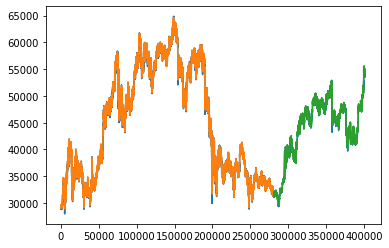

In [23]:
# lets plot the predictions on a graph and see how well it did
train_plot = np.empty_like(data_close)
train_plot[:,:] = np.nan
train_plot[series:len(trainPredictions)+series, :] = trainPredictions

test_plot = np.empty_like(data_close)
test_plot[:,:] = np.nan
test_plot[len(trainPredictions)+(series*2)+1:len(data_close)-1, :] = testPredictions

# plot on graph
plt.plot(scaler.inverse_transform(data_close))
plt.plot(train_plot)
plt.plot(test_plot)
plt.show()